In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import arviz as az
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from scipy import stats
import matplotlib as mpl

import warnings
warnings.filterwarnings("ignore")



In [2]:
path_to_data = "C:/Users/rwyde/Desktop/trazdox/data/filtered_data_csv.csv"
data = pd.read_csv(path_to_data)
data.head()


,Day,G1_avg,G1_sd,G2_avg,G2_sd,G3_avg,G3_sd,G4_avg,G4_sd,G5_avg,G5_sd,G6_avg,G6_sd
0,7,51.786507,20.212286,31.930893,16.927490,48.806049,19.286955,43.664264,19.417161,30.988742,17.752230,44.409795,13.040341
1,14,66.185535,27.352276,53.804666,21.294581,69.038249,35.959695,46.313592,27.260107,34.640653,25.398323,60.142226,16.147825
2,23,100.841313,48.551059,67.105632,29.538706,126.046100,42.178934,85.785176,68.526077,61.905680,33.892752,135.849364,62.744238
3,29,205.291993,85.584746,141.023314,53.179914,241.478202,111.850683,251.086596,140.093869,134.994293,65.107710,207.222552,91.554513
4,34,334.876240,106.083280,225.843888,92.229404,393.011416,100.606232,443.482321,223.956685,257.324806,123.482982,303.385114,117.382875


In [3]:
data_array = data.to_numpy()
days = data_array[:,0]
tumor_sizes = data_array[:,1::2]
tumor_sigmas = data_array[:,2::2]

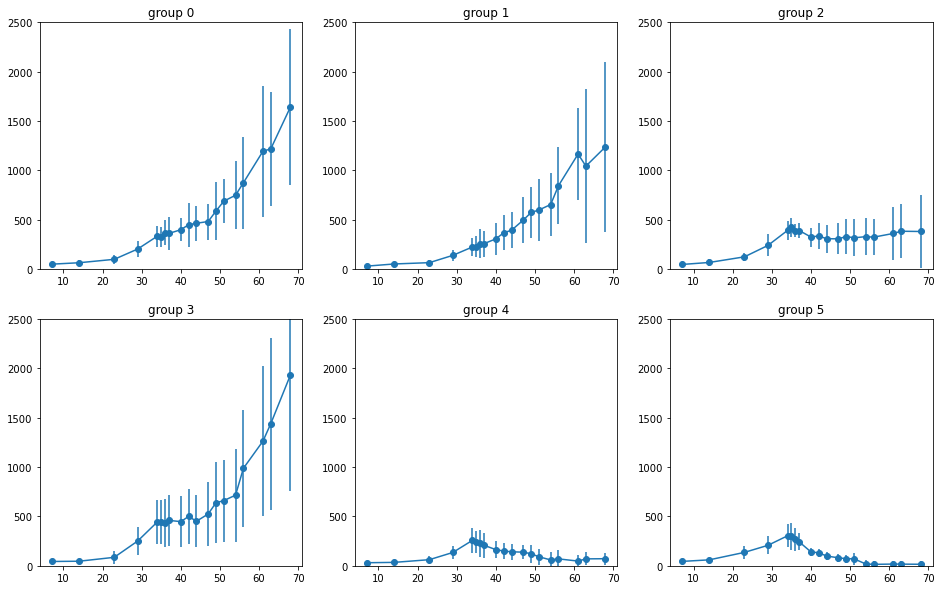

In [4]:
plt.figure(figsize=(16,10))
for ii in range(6):
    plt.subplot(2,3,ii+1)
    plt.ylim(0,2500)
    plt.scatter(days, tumor_sizes[:,ii])
    plt.errorbar(days, tumor_sizes[:,ii], tumor_sigmas[:,ii])
    plt.title("group {}".format(ii))
plt.show()

In [5]:
eps = 1e-2
y0 = np.array([0])

dox_dose_days = np.array([[2, 7]])
"""
switcher={
        ('dox',1): [39],
        
        ('her',2): [35,38],
        
        ('dox',3): [35],
        ('her',3): [36,39],
        
        ('her',4): [35,38],
        ('dox',4): [39],
        
        ('her',5): [35,38],
        ('dox',5): [35,38]
    }  
"""

    
def stiff_de(t, y, p):
    return [p[0]*y[0]]

#wrap the function to change the arguments order, so we can pass it to DifferentialEquation
def stiff_de_wrap(y, t, p):
    return stiff_de(t, y, p)[:]
    
ode_model = DifferentialEquation(
    func = stiff_de_wrap,
    times=days,
    n_states=1,
    n_theta=1,
    t0=0,    
)


with pm.Model() as model:
# Specify prior distributions for soem of our model parameters
    #dose = pm.Uniform('dose', 0, 100)
    r = pm.Uniform('r',0,1)
    
    # If we know one of the parameter values, we can simply pass the value.
    ode_solution = ode_model(y0=y0, theta=[r])
    # The ode_solution has a shape of (n_times, n_states)
    #print(ode_solution.shape)
    #print(sigma.shape)
    #print(ret['y'].shape)
    Y = pm.Normal('Y', mu=ode_solution.ravel(), sigma=tumor_sigmas[:,0].ravel(), observed=tumor_sizes[:,0].ravel())
    
    prior = pm.sample_prior_predictive()
    
    #step = pm.Slice()
    step = pm.Metropolis()
    trace = pm.sample(200, tune=100, cores=1, step=step)
    #trace = pm.sample(2000, tune=1000, target_accept = 0.9, cores=1, step=step)
    """
    posterior_predictive = pm.sample_posterior_predictive(trace)
    posterior_distribution = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

    print("plotting prior samples")
    #az.plot_trace(prior)
    traceplot(prior)
    print("plotting MCMC trace")
    #az.plot_trace(trace)
    traceplot(trace)
    print("plotting posterior samples")
    #az.plot_trace(posterior_predictive)
    traceplot(posterior_predictive)
    print("plotting posterior distribution")
    az.plot_posterior(posterior_distribution)
    #traceplot(posterior_distribution)
    """


Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [r]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 41 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


In [6]:
def from_posterior(param, samples):
    smin = np.min(samples)
    smax = np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    
    
    #what was never sampled should have a small probability but not 0
    # so we'll extend the domain and use linear approximation of density on it
    
    x = np.concatenate([[x[0] - 0.25*width], x, [x[-1] + 0.25*width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)


In [7]:
traces = [trace]

Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [r]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 40 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


Posterior distributions after 2 iterations


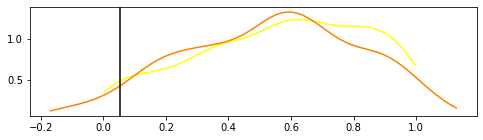

Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [r]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 44 seconds.
The number of effective samples is smaller than 25% for some parameters.


Posterior distributions after 3 iterations


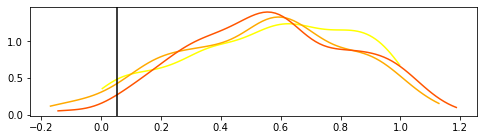

Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [r]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 45 seconds.
The number of effective samples is smaller than 25% for some parameters.


Posterior distributions after 4 iterations


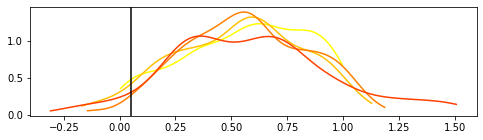

Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [r]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 50 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


Posterior distributions after 5 iterations


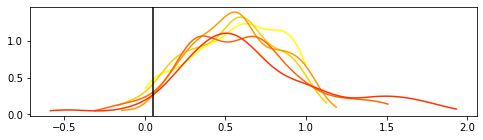

Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [r]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 51 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


Posterior distributions after 6 iterations


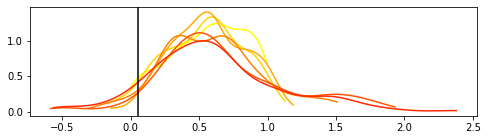

Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [r]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 57 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


Posterior distributions after 7 iterations


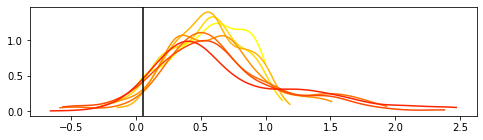

Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [r]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 61 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


Posterior distributions after 8 iterations


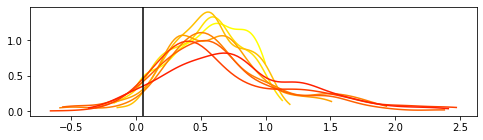

Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [r]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 64 seconds.
The number of effective samples is smaller than 25% for some parameters.


Posterior distributions after 9 iterations


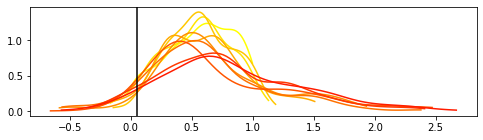

Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [r]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 73 seconds.
The number of effective samples is smaller than 25% for some parameters.


Posterior distributions after 10 iterations


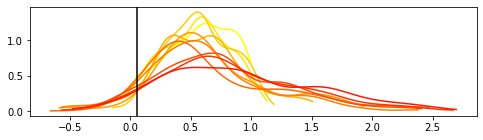

Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [r]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 64 seconds.
The number of effective samples is smaller than 25% for some parameters.


Posterior distributions after 11 iterations


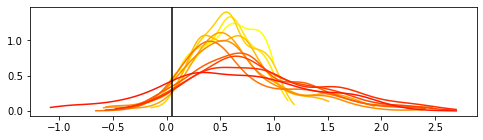

In [8]:
for _ in range(10):
    
    model = pm.Model()
    
    with model:
        
        #priors are posteriors from previous iteration
        r = from_posterior('r', trace['r'])
        
        ode_solution = ode_model(y0=y0, theta=[r])
        
        Y_obs = pm.Normal('Y_obs', mu=ode_solution.ravel(), sigma=tumor_sigmas[:,0].ravel(), observed=tumor_sizes[:,0].ravel())
        
        step = pm.Metropolis()
        trace = pm.sample(200, tune=100, cores=1, step=step)
        traces.append(trace)
        
        print("Posterior distributions after {} iterations".format(str(len(traces))))
        cmap = mpl.cm.autumn

        for param in ['r']:
            plt.figure(figsize=(8,2))
            for update_i, trace in enumerate(traces):
                samples = trace[param]
                smin = np.min(samples)
                smax = np.max(samples)
                x = np.linspace(smin, smax, 100)
                y = stats.gaussian_kde(samples)(x)
                plt.plot(x, y, color=cmap(1 - update_i / len(traces)))

            plt.axvline({'r': 0.053}[param], c='k')
            plt.show()
        